In [1]:
import numpy as np
from PIL import Image

filename = "./test/rain.jpg"
pixels = np.asarray(Image.open(filename))

In [2]:
from instapy.python_filters import *
from instapy.numpy_filters import *
grayscale_image_py= python_color2sepia(pixels)
grayscale_image_np = numpy_color2sepia(pixels)
np.where(np.not_equal(grayscale_image_py,grayscale_image_np)==True)

(array([185, 188, 195, 197, 197, 205, 219, 228, 248, 269, 301, 335, 342,
        356, 387]),
 array([558, 343, 387, 386, 389,  18, 463, 154, 507, 520, 168, 290, 335,
        383, 287]),
 array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]))

In [27]:
ineq = np.not_equal(grayscale_image_py,grayscale_image_np)
np.where(ineq[:,:,2]==False)

(array([ 27,  27,  27, ..., 399, 399, 399]),
 array([429, 430, 440, ..., 508, 519, 523]))

22

In [3]:
grayscale_image_np[185,558,:]

array([253, 226, 176], dtype=uint8)

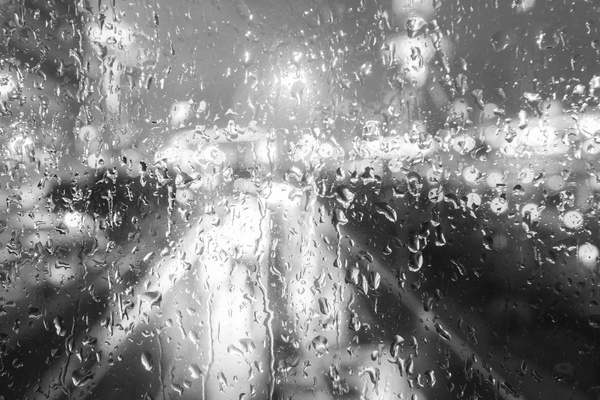

In [11]:
from instapy.numpy_filters import *
grayscale_image = numpy_color2gray(pixels)
grayscale_image = grayscale_image.astype("uint8")
Image.fromarray(grayscale_image)

In [5]:
from instapy.numba_filters import *
grayscale_image = numba_color2sepia(pixels)
#grayscale_image = grayscale_image.astype("uint8")
#Image.fromarray(grayscale_image)
#grayscale_image

In [3]:
#%timeit  numba_color2sepia(pixels)
%timeit  cython_color2sepia(pixels)
#%timeit  python_color2gray(pixels)

1.8 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [2]:
from instapy.cython_filters import *
grayscale_image = cython_color2sepia(pixels)
#grayscale_image = grayscale_image.astype("uint8")
#Image.fromarray(grayscale_image)


In [35]:

sepia_matrix = np.asarray([
    [ 0.393, 0.769, 0.189],
    [ 0.349, 0.686, 0.168],
    [ 0.272, 0.534, 0.131],
])
sep = pixels[0,0]*sepia_matrix
print(sep)
np.sum(sep, axis=1)

[[ 24.759 110.736  47.439]
 [ 21.987  98.784  42.168]
 [ 17.136  76.896  32.881]]


array([182.934, 162.939, 126.913])

In [37]:
pixels[0,0]

array([ 63, 144, 251], dtype=uint8)

In [39]:
im = np.empty_like(pixels)
for i in range(len(pixels)):
    for j in range(len(pixels[i])): 
        im[i,j,:] = np.clip(np.sum(pixels[i,j,:]*sepia_matrix,axis=1),a_min=0,a_max=255)
    #np.sum(sep, axis=1)

im = im.astype("uint8")

In [23]:
im = np.empty_like(pixels)
for i in range(len(pixels)):
    for j in range(len(pixels[i])):
        for n in range(3):
             im[i,j,n] = min(255,sum([p * s for p,s in zip(sepia_matrix[n],pixels[i,j])]))

#im = im.astype("uint8")

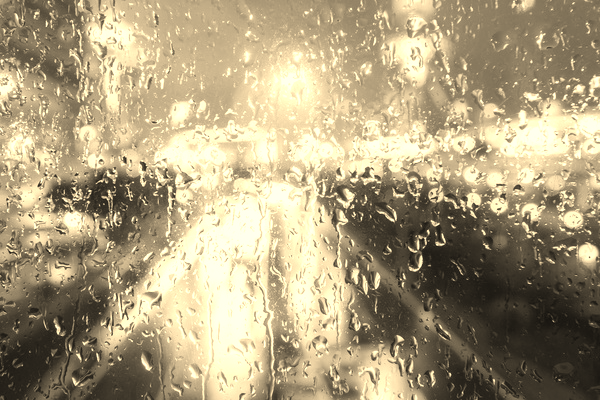

In [62]:
sepia_image= numba_color2sepia(pixels)
sepia_image = sepia_image.astype("uint8")
Image.fromarray(sepia_image)

In [63]:
%timeit  numba_color2sepia(pixels)

91.4 ms ± 574 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
%load_ext Cython

In [13]:
%%cython -a
import numpy as np
cimport numpy as np

cdef clip_to_255(double val):
    cdef int clipval = 255
    if val > clipval:
        return clipval
    else:
        return val

def cython_color2sepia(unsigned char[:,:,:] image):
    """Convert rgb pixel array to sepia

    Args:
        image (np.array)
    Returns:
        np.array: gray_image
    """

    cdef int nx = image.shape[1]
    cdef int ny = image.shape[0]

    cdef unsigned char[:,:,:] sepia_image = np.empty((ny,nx,3), dtype=np.uint8)

    cdef double[:,:] sepia_matrix = np.asarray(
        [
            [0.393, 0.769, 0.189],
            [0.349, 0.686, 0.168],
            [0.272, 0.534, 0.131],
        ]
    )
    cdef int i,j,n,m
    cdef double tmp

    for i in range(ny):
        for j in range(nx):
            for n in range(3):
                tmp = 0
                for m in range(3):
                    tmp = tmp + sepia_matrix[n, m] * image[i, j, m]
                
                sepia_image[i, j, n] = <unsigned char>min(tmp,255)
    
    return np.asarray(sepia_image)

In file included from /home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /home/oliverif/.cache/ipython/cython/_cython_magic_c7e0018f563911dd04a9a5efdc12d3b9.c:776:
/home/oliverif/.pyenv/versions/3.10.5/envs/dev/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/home/oliverif/.cache/ipython/cython/_cython_magic_c7e0018f563911dd04a9a5efdc12d3b9.c:2684:18: warning: ‘__pyx_f_46_cyth